## Жерноклеев Дмитрий 
### Курсовая работа. 

### Импортируем необходимые модули

In [1]:
# Агентное моделирование в Python можно реализовывать 
# с использованием модуля Mesa
# !pip install mesa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model # будем работать с модулем mesa
from mesa.time import RandomActivation
from mesa.time import BaseScheduler
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from tqdm import tqdm
import itertools
import math as mt
%matplotlib inline

In [3]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

In [ ]:
def read_func(f_name):
    df = pd.read_csv(f_name, sep=';', index_col='Название банка', 
                                  skiprows=3, encoding='cp1251')
    df = df.iloc[:, [4, 5]]
    df.rename(columns={'Декабрь, 2021, тыс. рублей': '12.21, тыс.руб.', 
                        'Сентябрь, 2021, тыс. рублей': '09.21, тыс.руб.'}, inplace=True)
    # print(df.head(10))
    # print(df.shape)

In [4]:
df_firm_credits = pd.read_csv('credits_firms.csv', sep=';', index_col='Название банка', 
                              skiprows=3, encoding='cp1251')
# df_firm_credits.head()
df_firm_credits = df_firm_credits.iloc[:, [4, 5]]
df_firm_credits.rename(columns={'Декабрь, 2021, тыс. рублей': '12.21, тыс.руб.', 
                                   'Сентябрь, 2021, тыс. рублей': '09.21, тыс.руб.'}, inplace=True)
df_firm_credits.head(10)

,"12.21, тыс.руб.","09.21, тыс.руб."
Название банка,,
СберБанк,"16 188 081 039,00","15 345 023 839,00"
ВТБ,"7 763 399 115,00","7 807 492 708,00"
Газпромбанк,"4 856 033 849,00","4 678 178 943,00"
Альфа-Банк,"2 513 740 158,00","2 306 976 222,00"
Московский Кредитный Банк,"2 424 648 519,00","2 208 405 585,00"
Россельхозбанк,"2 261 167 659,00","2 195 697 483,00"
Национальный Клиринговый Центр,"1 947 964 570,00","1 892 163 143,00"
Банк Открытие,"1 466 838 228,00","1 352 997 998,00"
Траст,"938 263 868,00","943 254 562,00"


In [5]:
df_individ_credits = pd.read_csv('credits_individ.csv', sep=';', index_col='Название банка', skiprows=3, encoding='cp1251')
# df_individ_credits.head()
df_individ_credits = df_individ_credits.iloc[:, [4, 5]]
df_individ_credits.rename(columns={'Декабрь, 2021, тыс. рублей': '12.21, тыс.руб.', 
                                   'Сентябрь, 2021, тыс. рублей': '09.21, тыс.руб.'}, inplace=True)
df_individ_credits.head(10)

,"12.21, тыс.руб.","09.21, тыс.руб."
Название банка,,
СберБанк,"10 268 477 809,00","9 669 352 698,00"
ВТБ,"4 002 715 394,00","3 900 892 142,00"
Альфа-Банк,"1 236 427 053,00","1 132 705 702,00"
Газпромбанк,"700 541 953,00","724 134 355,00"
Россельхозбанк,"603 701 097,00","604 548 864,00"
Тинькофф Банк,"562 840 758,00","523 090 510,00"
Банк Открытие,"554 398 542,00","543 929 937,00"
Росбанк,"544 216 710,00","543 140 552,00"
Совкомбанк,"486 616 668,00","417 106 784,00"


In [6]:
df_firm_credits.shape, df_individ_credits.shape

((362, 2), (362, 2))

In [7]:
df_joined = df_firm_credits.join(df_individ_credits, how='inner', lsuffix=' фирмы', rsuffix=' физ.лица')
for col in df_joined.columns:
    df_joined[col] = df_joined[col].str.replace(' ', '')
    df_joined[col] = df_joined[col].str.replace(',', '.').astype(float)
df_joined['Dec 2021 cred portf'] = df_joined['12.21, тыс.руб. фирмы'] + df_joined['12.21, тыс.руб. физ.лица']
df_joined['Sept 2021 cred portf'] = df_joined['09.21, тыс.руб. фирмы'] + df_joined['09.21, тыс.руб. физ.лица']
df_cred_portf = df_joined[['Dec 2021 cred portf', 'Sept 2021 cred portf']]\
                        .sort_values('Dec 2021 cred portf', ascending=False)
df_cred_portf.head(20)

,Dec 2021 cred portf,Sept 2021 cred portf
Название банка,,
СберБанк,2.645656e+10,2.501438e+10
ВТБ,1.176611e+10,1.170838e+10
Газпромбанк,5.556576e+09,5.402313e+09
Альфа-Банк,3.750167e+09,3.439682e+09
Россельхозбанк,2.864869e+09,2.800246e+09
Московский Кредитный Банк,2.584704e+09,2.357967e+09
Банк Открытие,2.021237e+09,1.896928e+09
Национальный Клиринговый Центр,1.947965e+09,1.892163e+09
Совкомбанк,1.133929e+09,9.871598e+08


In [9]:
banks_of_interest_lst = ['СберБанк', 'ВТБ', 'Газпромбанк', 'Альфа-Банк', 
                     'Россельхозбанк', 'Московский Кредитный Банк',
                    'Банк Открытие', 'Совкомбанк', 'Райффайзенбанк',
                    'Росбанк']
df_cred_portf = df_cred_portf.loc[banks_of_interest_lst]
df_cred_portf

,Dec 2021 cred portf,Sept 2021 cred portf
Название банка,,
СберБанк,2.645656e+10,2.501438e+10
ВТБ,1.176611e+10,1.170838e+10
Газпромбанк,5.556576e+09,5.402313e+09
Альфа-Банк,3.750167e+09,3.439682e+09
Россельхозбанк,2.864869e+09,2.800246e+09
Московский Кредитный Банк,2.584704e+09,2.357967e+09
Банк Открытие,2.021237e+09,1.896928e+09
Совкомбанк,1.133929e+09,9.871598e+08
Райффайзенбанк,9.904486e+08,9.354995e+08


In [27]:
def f(x):
    elast = 0.2
    k = (10 ** 13) * (mt.e ** (2 * elast))
    return k * mt.exp(-elast * x) if x >=2 else 10 ** 13

In [28]:
x_arr = np.linspace(0, 40, 100)
y_arr = list(map(f, x_arr))

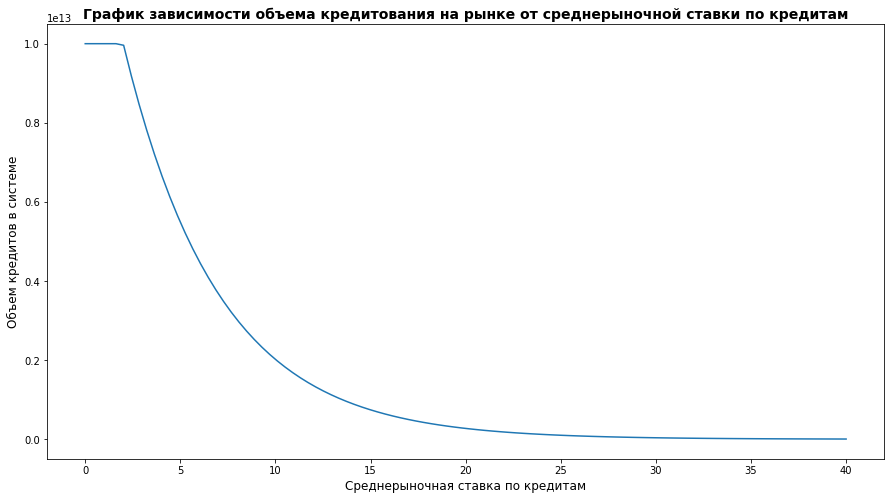

In [29]:
plt.figure(figsize=(15, 8))
plt.xlabel('Среднерыночная ставка по кредитам', fontsize=12)
plt.ylabel('Объем кредитов в системе', fontsize=12)
plt.title('График зависимости объема кредитования на рынке от среднерыночной ставки по кредитам', fontsize=14, weight='bold')
plt.plot(x_arr, y_arr)
plt.show()

### Создадим класс для агентов нашей модели

In [ ]:
class BankSysAgent(Agent):
    def __init__(self, unique_id, model, agent_type, name):
        super().__init__(unique_id, model)
        self.agent_type = agent_type # тип агента (ЦБ, банк, частный сектор (ЧС))
        self.name = name # имя (название) агента
    
    def step(self):
        if self.agent_type == 'CB': # описание шага для ЦБ (первый раунд)
            # if self.model.step_num > 0: # счетчик шагов?
            self.model.key_rate += self.model.k 
                                  * (self.model.rate_quart_to_year(
                                      self.model.market_cred_portfolio_delt)
                                       - self.model.target_inflat) # вычисление ключевой ставки
        elif self.agent_type == 'Bank': # описание шага для банков (второй раунд)
            pass        
        else: # elif self.agent_type == 'PrivSect':
            # if self.model.step_num > 0: # с
            credit_rate_sum, deposit_rate_sum = 0, 0
            for a in self.model.schedule.agents:
                # if a.agent_type == 'Bank':
                rate_sum += self.model.credit_rate_dict.get(a.name, 0) # a.rate     
                deposit_rate_sum += self.model.deposit_rate_dict.get(a.name, 0)
            mean_bank_credit_rate = rate_sum / self.model.num_banks # считаем среднерыночную ставку
                                                                    # и объем взятых ЧС кредитов
            self.model.credit_vol = self.model.credit_vol_calc(mean_bank_credit_rate,
                                                                self.model.pelast, self.model.start_balance)
            self.model.deposit_vol = self.model.credit_vol # полагаем объем депозитов = объему кредитов
            for a in self.model.schedule.agents:
                if a.agent_type == 'Bank':
                    bank_credit_rate_spread = self.model.credit_rate_dict[a.name]
                                              - (rate_sum - self.model.credit_rate_dict[a.name]) 
                                              / (self.model.num_banks - 1)
                    cred_portfolio_delt = self.model.alpha_dict[a.name] 
                                         * self.model.credit_vol
                                         * bank_credit_rate_spread
                    self.model.cred_portfolio_dict[a.name] += cred_portfolio_delt
                    
                    bank_deposit_rate_spread = self.model.deposit_rate_dict[a.name]
                                              - (deposit_rate_sum - self.model.deposit_rate_dict[a.name]) 
                                              / (self.model.num_banks - 1)
                    deposit_portfolio_delt = self.model.alpha_dict[a.name] 
                                            * self.model.deposit_vol
                                            * bank_deposit_rate_spread
                    self.model.deposit_portfolio_dict[a.name] += deposit_portfolio_delt
                    CBMoney = self.model.deposit_portfolio_dict[a.name] 
                             - self.model.cred_portfolio_dict[a.name]
            
        raise NotImplementedError    
    

### Также создадим класс собственно для самой модели

In [ ]:
class BankSysModel(Model):
    def __init__(self, key_rate, market_cred_portfolio_delt, pelast,
                 start_balance, k=0.3, N=12, target_inflat=4):
        self.num_agents = N # общее число агентов
        self.num_banks = N - 2 # число банков ( = общее число агентов - ЦБ - ЧС)
        self.key_rate = key_rate # текущая ключевая ставка (в %)
        self.k = k # коэффициент (для спреда) из формулы ключевой ставки 
        self.target_inflat = target_inflat # таргетная инфляция (в %)
        self.market_cred_portfolio_delt = market_cred_portfolio_delt # прирост портфеля за прошлый период
        self.pelast = pelast # эластичность частного сектора
        self.start_balance = start_balance # стартовый баланс системы
        
        self.schedule = BaseScheduler(self) # добавим шедулер
        
        
        # -----
        self.pairwise = pairwise # режим взаимодействия
        if self.pairwise == False:
            self.mu /= (self.num_agents - 1)
        
        self.schedule = RandomActivation(self) # добавим шедулер
        x_rand_gen = np.random.uniform(-1, 1, self.num_agents) # нагенерим рандомные x для инициализации агентов
        p_pos_div_p_neg = (1 + self.delta) / (1 - self.delta) # отношение p+/p-, полученное при раскрытии модуля
                                                              # в предположении, что положительных всегда не меньше
        N_neg_extr = int((self.num_agents * self.p_e) / (1 + p_pos_div_p_neg)) # число отриц. экстр.
        N_pos_extr = int(self.num_agents * self.p_e) - N_neg_extr # число полож. экстрем.
                        # формулы вывел на бумаге, еще пользуюсь соображением, что их сумма есть общее число экстрем. 
            
        idxs_neg_extr = np.argpartition(x_rand_gen, N_neg_extr)[:N_neg_extr] # объявляем в качестве экстрем. хвосты слева и справа
        idxs_pos_extr = np.argpartition(x_rand_gen, -N_pos_extr)[-N_pos_extr:] # используя их числа, вычисленные ранее, 
                                                                               # находим индексы экстремистов в массиве мнений x
        if self.pairwise: 
            self.made_step = [] # массив, куда будем закидывать тех, 
                                # кто поучаствовал на шаге в парном взаимодействии
        else:
            self.xs = [0 for _ in range(self.num_agents)] # списки для пересчитанных значений
            self.us = [0 for _ in range(self.num_agents)]
        # Инициализируем агентов и закидываем в шедулер
        for i, x in enumerate(x_rand_gen):
            if (i not in idxs_neg_extr) and (i not in idxs_pos_extr):  
                a = CustomAgent(i, self, x, self.u)
                self.schedule.add(a)
            else:
                a = CustomAgent(i, self, x, self.u_e, True)
                self.schedule.add(a)
                
        self.datacollector = DataCollector(
            agent_reporters={"Opinions": "x"}) # для сбора данных по прогону модели
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if self.pairwise:
            self.made_step = []
        else:
            for a in self.schedule.agents:
                a.x = self.xs[a.unique_id]
                a.u = self.us[a.unique_id]
            self.xs = [0 for _ in range(self.num_agents)]
            self.us = [0 for _ in range(self.num_agents)]
    
    @staticmethod
    def rate_quart_to_year(rate):
        return ((1 + rate / 100) ** 4 - 1) * 100
    
    @staticmethod
    def credit_vol_calc(x, elast, start_balance):
        c = (10 * start_balance) * (mt.e ** (2 * elast))
        return c * mt.exp(-elast * x) if x >=2 else 10 * start_balance

### Произведем запуск модели 

In [ ]:
model = BankSysModel(key_rate, market_cred_portfolio_delt, pelast,
                     k=0.3, N=12, target_inflat=4)
for i in range(40):
    model.step()

In [ ]:
# opinion_data = model.datacollector.get_agent_vars_dataframe()
# opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
# plt.show()